<div style="text-align: right;">© 2025 Moses Boudourides. All Rights Reserved.</div>

# HPRA for Hyperedge Prediction 

This notebook applies the **HPRA** (**Hyperedge Prediction using Resource Allocation**) algorithm to predict specific hidden hyperedges. 

## Input Format
- **Hypergraph**: Dictionary with hyperedge keys and node sets as values
- **Hidden Hyperedges**: List of hyperedge keys to hide and predict
- Nodes can be integers or strings

## Output
- **ML Scores**: F1, Recall, Precision, Accuracy, ROC-AUC, Log Loss, Matthews Coefficient
- **Structural Evaluation Metrics**: These metrics measure how well the HPRA algorithm groups nodes with strong connectivity patterns together in predicted hyperedges, comparing the internal connectivity of predictions against random baselines and analyzing whether the algorithm preferentially selects high-degree nodes.
- **ROC-AUC Curves** for all examples
- **Comprehensive Comparison Table** with all metrics

In [1]:
import numpy as np
import scipy.sparse as sp
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss, matthews_corrcoef
import random
import warnings
import itertools
import collections
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
from datetime import datetime
from pathlib import Path
warnings.filterwarnings('ignore')

# Set matplotlib style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)

## Random Hypergraph Generator

In [2]:
def hypergraph_random_creator(vertices, hyperedge_names, m, minv, maxv, weighted=False, weight_range=(1, 10)):
    """
    Creates a random hypergraph with custom vertex and hyperedge names.

    Parameters:
    - vertices (list of int or str): List of vertex names.
    - hyperedge_names (list of str): List of hyperedge names.
    - m (int): Number of hyperedges to create (must be <= length of hyperedge_names).
    - minv (int): Minimum number of nodes in a hyperedge.
    - maxv (int): Maximum number of nodes in a hyperedge (must be > minv).
    - weighted (bool): If True, creates a weighted hypergraph where nodes have weights.
    - weight_range (tuple): Range of weights (min, max) to assign to nodes if weighted=True.

    Returns:
    - hg_d (dict): A dictionary representing the hypergraph, with keys as hyperedge names and values as sets of nodes.
                   If weighted=True, values are dictionaries mapping nodes to their weights.
    """
    # Check if m is valid
    if m > len(hyperedge_names):
        raise ValueError("m cannot be greater than the number of hyperedge names provided.")
    
    if minv > maxv:
        raise ValueError("minv must be less than or equal to maxv.")
    
    if minv < 1:
        raise ValueError("minv must be at least 1.")
    
    if maxv > len(vertices):
        raise ValueError("maxv cannot be greater than the number of vertices.")
    
    hg_d = {}
    for k in range(m):
        # Random number of nodes for this hyperedge
        r = random.randint(minv, maxv)
        
        # Sample nodes without replacement
        nodes = random.sample(vertices, r)
        
        # Sort nodes for consistency
        sorted_nodes = sorted(nodes)

        # If weighted, create a dictionary mapping nodes to weights
        if weighted:
            sorted_nodes = {node: random.randint(weight_range[0], weight_range[1]) for node in sorted_nodes}
        else:
            # Convert to set for unweighted hypergraphs
            sorted_nodes = set(sorted_nodes)
        
        hg_d[hyperedge_names[k]] = sorted_nodes
        
    return hg_d

## Hypergraph Utilities

In [3]:
def hypergraph_dict_to_incidence_matrix(hypergraph_dict):
    """
    Convert dictionary-based hypergraph to incidence matrix
    """
    # Get all unique nodes
    all_nodes = set()
    for nodes in hypergraph_dict.values():
        if isinstance(nodes, dict):
            all_nodes.update(nodes.keys())
        else:
            all_nodes.update(nodes)
    
    # Create mappings
    node_to_idx = {node: idx for idx, node in enumerate(sorted(list(all_nodes)))}
    idx_to_node = {idx: node for node, idx in node_to_idx.items()}
    
    hyperedge_keys = list(hypergraph_dict.keys())
    hyperedge_to_idx = {he: idx for idx, he in enumerate(hyperedge_keys)}
    idx_to_hyperedge = {idx: he for he, idx in hyperedge_to_idx.items()}
    
    # Create incidence matrix
    n_nodes = len(all_nodes)
    n_hyperedges = len(hypergraph_dict)
    
    H = sp.lil_matrix((n_nodes, n_hyperedges), dtype=float)
    
    for he_idx, (he_key, nodes) in enumerate(hypergraph_dict.items()):
        if isinstance(nodes, dict):
            for node, weight in nodes.items():
                node_idx = node_to_idx[node]
                H[node_idx, he_idx] = weight
        else:
            for node in nodes:
                node_idx = node_to_idx[node]
                H[node_idx, he_idx] = 1.0
    
    return H.tocsr(), node_to_idx, idx_to_node, hyperedge_to_idx, idx_to_hyperedge

def get_adj_matrix(H):
    """
    Compute adjacency matrix from incidence matrix using node degree preserving reduction
    """
    # Computing inverse hyperedge degree Matrix
    d_e = np.squeeze(np.asarray(sp.csr_matrix.sum(H, axis=0)))
    d_e_adjusted = np.where(d_e <= 1, 1, d_e - 1) # Adjust degree: degree 1 becomes 1, others degree-1
    
    D_e_inv = sp.spdiags(np.reciprocal(d_e_adjusted), [0], H.shape[1], H.shape[1], format="csr")
    
    # Computing node degree preserving reduction
    A_ndp = H.dot(D_e_inv.dot(H.transpose()))
    A_ndp = A_ndp - sp.spdiags(A_ndp.diagonal(), [0], A_ndp.shape[0], A_ndp.shape[1], format="csr")
    
    return A_ndp

## HPRA Algorithm Implementation

In [4]:
def get_pref_node(H):
    """
    Get a node based on preferential attachment (degree-based selection)
    """
    node_degree = 0
    max_attempts = 100
    attempts = 0
    
    while node_degree == 0 and attempts < max_attempts:
        d_v = np.squeeze(np.asarray(sp.csr_matrix.sum(H, axis=1)))
        if np.sum(d_v) == 0:
            return np.random.randint(0, H.shape[0])
        
        node_id = np.random.choice(np.arange(len(d_v)), replace=True, p=d_v/np.sum(d_v))
        node_degree = d_v[node_id]
        attempts += 1
    
    return node_id

def compute_NHAS(hyperedge_nodes, hra_scores, candidate_nodes):
    """
    Compute Node-Hyperedge Attachment Scores (NHAS) for candidate nodes
    """
    scores = []
    valid_candidates = []
    
    for candidate_node in candidate_nodes:
        if candidate_node not in hyperedge_nodes:
            score = 0
            for node in hyperedge_nodes:
                score += hra_scores[node, candidate_node]
            scores.append(max(0, score))  # Ensure non-negative scores
            valid_candidates.append(candidate_node)
    
    return valid_candidates, scores

def predict_hyperedge(H, hra_scores, edge_degree, node_to_idx, idx_to_node):
    """
    Predict a new hyperedge using HPRA algorithm
    """
    hyperedge_indices = set()
    
    # Get initial node based on preferential attachment
    initial_node_idx = get_pref_node(H)
    hyperedge_indices.add(initial_node_idx)
    
    nodes_count = H.shape[0]
    max_iterations = edge_degree * 2  # Prevent infinite loops
    iterations = 0
    
    while len(hyperedge_indices) < edge_degree and iterations < max_iterations:
        candidate_nodes = list(range(nodes_count))
        valid_candidates, scores = compute_NHAS(hyperedge_indices, hra_scores, candidate_nodes)
        
        if not valid_candidates or np.sum(scores) == 0:
            # If no valid candidates or all scores are zero, select randomly
            remaining_nodes = [i for i in range(nodes_count) if i not in hyperedge_indices]
            if remaining_nodes:
                selected_node = np.random.choice(remaining_nodes)
                hyperedge_indices.add(selected_node)
            else:
                break
        else:
            # Select node based on NHAS scores
            probabilities = np.array(scores) / np.sum(scores)
            selected_node = np.random.choice(valid_candidates, p=probabilities)
            hyperedge_indices.add(selected_node)
        
        iterations += 1
    
    # Convert back to original node identifiers
    predicted_hyperedge = {idx_to_node[idx] for idx in hyperedge_indices}
    
    return predicted_hyperedge

## Enhanced Evaluation Metrics

In [5]:
# Enhanced Evaluation with Jaccard Similarity
def jaccard_similarity(set1, set2):
    """Compute Jaccard similarity between two sets"""
    if len(set1) == 0 and len(set2) == 0:
        return 1.0
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0.0

def find_best_jaccard_matches(predicted_hyperedges, hidden_hyperedges_nodes):
    """Find best Jaccard similarity matches between predicted and hidden hyperedges"""
    best_similarities = []
    best_matches = []
    
    for hidden_he in hidden_hyperedges_nodes:
        best_sim = 0.0
        best_pred = None
        
        for pred_he in predicted_hyperedges:
            sim = jaccard_similarity(set(hidden_he), set(pred_he))
            if sim > best_sim:
                best_sim = sim
                best_pred = pred_he
        
        best_similarities.append(best_sim)
        best_matches.append(best_pred)
    
    return best_similarities, best_matches

def enhanced_classification_data(predicted_hyperedges, hidden_hyperedges_nodes, hra_scores, node_to_idx):
    """Generate enhanced classification data using both exact matching and Jaccard similarity"""
    # Original exact matching
    y_true_exact, y_scores_exact = generate_classification_data(predicted_hyperedges, hidden_hyperedges_nodes, hra_scores, node_to_idx)
    
    # Jaccard similarity based evaluation
    jaccard_sims, best_matches = find_best_jaccard_matches(predicted_hyperedges, hidden_hyperedges_nodes)
    avg_jaccard = np.mean(jaccard_sims) if jaccard_sims else 0.0
    
    # Create binary labels based on Jaccard threshold
    jaccard_threshold = 0.3  # Consider similarity > 0.3 as positive
    y_true_jaccard = []
    y_scores_jaccard = []
    
    for pred_he in predicted_hyperedges:
        max_jaccard = 0.0
        for hidden_he in hidden_hyperedges_nodes:
            jaccard = jaccard_similarity(set(hidden_he), set(pred_he))
            max_jaccard = max(max_jaccard, jaccard)
        
        y_true_jaccard.append(1 if max_jaccard > jaccard_threshold else 0)
        y_scores_jaccard.append(max_jaccard)
    
    return {
        "exact_matching": {"y_true": y_true_exact, "y_scores": y_scores_exact},
        "jaccard_similarity": {"y_true": y_true_jaccard, "y_scores": y_scores_jaccard},
        "avg_jaccard": avg_jaccard,
        "best_jaccard_similarities": jaccard_sims
    }

# Traditional ML Metrics
def compute_auc(y_true, y_scores):
    """Compute ROC-AUC score"""
    try:
        if len(set(y_true)) < 2:
            return 0.5  # Only one class present
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)
        auc = metrics.auc(fpr, tpr)
        return auc
    except:
        return 0.5  # Random classifier baseline

def compute_precision(y_true, y_pred):
    """Compute precision score"""
    return metrics.precision_score(y_true, y_pred, average='binary', zero_division=0)

def compute_recall(y_true, y_pred):
    """Compute recall score"""
    return metrics.recall_score(y_true, y_pred, average='binary', zero_division=0)

def compute_f1_score(y_true, y_pred):
    """Compute F1 score"""
    return metrics.f1_score(y_true, y_pred, average='binary', zero_division=0)

def compute_accuracy(y_true, y_pred):
    """Compute accuracy score"""
    return accuracy_score(y_true, y_pred)

def compute_log_loss(y_true, y_proba):
    """Compute log loss"""
    try:
        # Ensure probabilities are in valid range [eps, 1-eps]
        eps = 1e-15
        y_proba = np.clip(y_proba, eps, 1 - eps)
        return log_loss(y_true, y_proba)
    except:
        return float('inf')

def compute_matthews_corrcoef(y_true, y_pred):
    """Compute Matthews correlation coefficient"""
    try:
        return matthews_corrcoef(y_true, y_pred)
    except:
        return 0.0  # No correlation baseline

def compute_all_ml_scores(y_true, y_pred, y_scores=None):
    """Compute all 7 ML scores"""
    scores = {}
    
    # Binary classification metrics
    scores['precision'] = compute_precision(y_true, y_pred)
    scores['recall'] = compute_recall(y_true, y_pred)
    scores['f1'] = compute_f1_score(y_true, y_pred)
    scores['accuracy'] = compute_accuracy(y_true, y_pred)
    scores['matthews_corrcoef'] = compute_matthews_corrcoef(y_true, y_pred)
    
    # Metrics requiring probability scores
    if y_scores is not None:
        scores['roc_auc'] = compute_auc(y_true, y_scores)
        # Convert scores to probabilities for log loss
        y_proba = 1 / (1 + np.exp(-np.array(y_scores)))  # Sigmoid transformation
        scores['log_loss'] = compute_log_loss(y_true, y_proba)
    else:
        scores['roc_auc'] = 0.5
        scores['log_loss'] = float('inf')
    
    return scores

# Structural Metrics
def calculate_internal_connectivity(hyperedge, hra_scores, node_to_idx):
    """Calculate the average pairwise HRA score within a hyperedge."""
    node_indices = [node_to_idx[node] for node in hyperedge if node in node_to_idx]
    if len(node_indices) < 2:
        return 0.0
    
    total_score = 0
    num_pairs = 0
    for i, node1_idx in enumerate(node_indices):
        for node2_idx in node_indices[i+1:]:
            total_score += hra_scores[node1_idx, node2_idx]
            num_pairs += 1
            
    return total_score / num_pairs if num_pairs > 0 else 0.0

def calculate_random_baseline_connectivity(hra_scores, node_to_idx, size, num_samples=100):
    """Calculate the average internal connectivity for random hyperedges of a given size."""
    if size < 2 or size > len(node_to_idx):
        return 0.0
        
    all_node_indices = list(node_to_idx.values())
    total_random_score = 0
    valid_samples = 0
    
    for _ in range(num_samples):
        random_indices = random.sample(all_node_indices, size)
        if len(random_indices) < 2:
            continue
            
        current_score = 0
        num_pairs = 0
        for i, node1_idx in enumerate(random_indices):
            for node2_idx in random_indices[i+1:]:
                current_score += hra_scores[node1_idx, node2_idx]
                num_pairs += 1
        
        if num_pairs > 0:
            total_random_score += current_score / num_pairs
            valid_samples += 1
            
    return total_random_score / valid_samples if valid_samples > 0 else 0.0

def analyze_node_degrees(hyperedges, H, node_to_idx):
    """Analyze the degree distribution of nodes in given hyperedges compared to overall."""
    all_node_degrees = np.squeeze(np.asarray(H.sum(axis=1)))
    avg_overall_degree = np.mean(all_node_degrees)
    
    degrees_in_hyperedges = []
    for he in hyperedges:
        for node in he:
            if node in node_to_idx:
                degrees_in_hyperedges.append(all_node_degrees[node_to_idx[node]])
                
    avg_degree_in_hyperedges = np.mean(degrees_in_hyperedges) if degrees_in_hyperedges else 0.0
    
    return avg_overall_degree, avg_degree_in_hyperedges

def analyze_hyperedge_sizes(original_hyperedges, predicted_hyperedges):
    """Compare the size distribution of original and predicted hyperedges."""
    original_sizes = [len(he) for he in original_hyperedges]
    predicted_sizes = [len(he) for he in predicted_hyperedges]
    
    avg_original_size = np.mean(original_sizes) if original_sizes else 0.0
    avg_predicted_size = np.mean(predicted_sizes) if predicted_sizes else 0.0
    
    return avg_original_size, avg_predicted_size, collections.Counter(original_sizes), collections.Counter(predicted_sizes)

def generate_classification_data(predicted_hyperedges, original_hyperedges_nodes, hra_scores, node_to_idx, num_negative_samples=None):
    """Generate classification data for ML evaluation with balanced classes."""
    # Create set of original hyperedges
    original_hyperedges_set = set()
    for nodes in original_hyperedges_nodes:
        original_hyperedges_set.add(frozenset(nodes))
    
    y_true = []
    y_scores = []
    
    # Positive examples: predicted hyperedges that exist in original
    positive_count = 0
    for pred_he in predicted_hyperedges:
        exists = frozenset(pred_he) in original_hyperedges_set
        y_true.append(1 if exists else 0)
        if exists:
            positive_count += 1
        
        # Compute score based on HRA values
        score = calculate_internal_connectivity(pred_he, hra_scores, node_to_idx)
        y_scores.append(score)
    
    # If we have very few positives, generate some negative examples for balance
    if positive_count < len(predicted_hyperedges) * 0.1:  # Less than 10% positive
        if num_negative_samples is None:
            num_negative_samples = min(len(predicted_hyperedges), 50)
        
        # Generate random hyperedges as negative examples
        all_nodes = list(node_to_idx.keys())
        predicted_sizes = [len(he) for he in predicted_hyperedges]
        
        for _ in range(num_negative_samples):
            size = np.random.choice(predicted_sizes) if predicted_sizes else 3
            if size <= len(all_nodes):
                random_he = set(random.sample(all_nodes, size))
                exists = frozenset(random_he) in original_hyperedges_set
                y_true.append(1 if exists else 0)
                
                score = calculate_internal_connectivity(random_he, hra_scores, node_to_idx)
                y_scores.append(score)
    
    return y_true, y_scores

def plot_roc_curve(y_true, y_scores, title="ROC Curve"):
    """Plot ROC curve and return AUC score."""
    try:
        if len(set(y_true)) < 2:
            print(f"ROC curve not generated for {title}: Only one class present")
            return 0.5
            
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)
        auc_score = metrics.auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()
        
        return auc_score
    except Exception as e:
        print(f"Could not generate ROC curve for {title}: {e}")
        return 0.5

## Enhanced Analysis Function

In [6]:
def specific_hyperedge_prediction_analysis(hypergraph_dict, hidden_hyperedges, num_predictions=200, num_runs=5, random_seed=42, plot_roc=True):
    """
    Perform enhanced specific hyperedge prediction analysis using HPRA algorithm with multiple runs.
    
    Args:
        hypergraph_dict: Dictionary with hyperedge keys and node sets as values
        hidden_hyperedges: List of hyperedge keys to hide and predict
        num_predictions: Number of prediction attempts per run
        num_runs: Number of independent runs to average over
        random_seed: Base random seed for reproducibility
        plot_roc: Whether to plot ROC curve
        
    Returns:
        results: Dictionary containing all analysis results and scores
    """
    print("Starting Enhanced Specific Hyperedge Prediction Analysis...")
    print(f"Original hypergraph: {len(hypergraph_dict)} hyperedges")
    print(f"Hidden hyperedges: {hidden_hyperedges}")
    print(f"Running {num_runs} independent runs with {num_predictions} predictions each")
    
    # Validate hidden hyperedges
    for he_key in hidden_hyperedges:
        if he_key not in hypergraph_dict:
            raise ValueError(f"Hidden hyperedge '{he_key}' not found in hypergraph")
    
    # Store hidden hyperedges and their nodes
    hidden_hyperedges_nodes = []
    for he_key in hidden_hyperedges:
        nodes = hypergraph_dict[he_key]
        if isinstance(nodes, dict):
            hidden_hyperedges_nodes.append(set(nodes.keys()))
        else:
            hidden_hyperedges_nodes.append(set(nodes))
    
    # Create training hypergraph (without hidden hyperedges)
    training_hypergraph = {k: v for k, v in hypergraph_dict.items() if k not in hidden_hyperedges}
    print(f"Training hypergraph: {len(training_hypergraph)} hyperedges (removed {len(hidden_hyperedges)} hidden)")
    
    # Convert training hypergraph to incidence matrix
    H_train, node_to_idx, idx_to_node, hyperedge_to_idx, idx_to_hyperedge = hypergraph_dict_to_incidence_matrix(training_hypergraph)
    print(f"Training incidence matrix shape: {H_train.shape} (nodes x hyperedges)")
    
    # Compute adjacency matrix (HRA scores) from training data
    A_ndp = get_adj_matrix(H_train)
    print("Computed adjacency matrix for HRA scores from training data")
    
    # Get hidden hyperedge sizes for prediction
    hidden_sizes = [len(nodes) for nodes in hidden_hyperedges_nodes]
    avg_hidden_size = np.mean(hidden_sizes) if hidden_sizes else 0.0
    print(f"Average hidden hyperedge size: {avg_hidden_size:.2f}")
    
    # Run multiple independent analyses
    all_run_results = []
    all_jaccard_scores = []
    all_ml_scores_exact = []
    all_ml_scores_jaccard = []
    
    for run in range(num_runs):
        current_seed = random_seed + run * 1000
        np.random.seed(current_seed)
        random.seed(current_seed)
        
        print(f"\nRun {run + 1}/{num_runs} (seed: {current_seed})")
        
        # Generate predictions for this run
        predicted_hyperedges = []
        for i in range(num_predictions):
            target_size = np.random.choice(hidden_sizes) if hidden_sizes else 3
            predicted_he = predict_hyperedge(H_train, A_ndp, target_size, node_to_idx, idx_to_node)
            predicted_hyperedges.append(predicted_he)
        
        # Enhanced evaluation for this run
        enhanced_data = enhanced_classification_data(predicted_hyperedges, hidden_hyperedges_nodes, A_ndp, node_to_idx)
        
        # Compute ML scores for exact matching
        y_true_exact = enhanced_data["exact_matching"]["y_true"]
        y_scores_exact = enhanced_data["exact_matching"]["y_scores"]
        threshold_exact = np.median(y_scores_exact) if y_scores_exact else 0.0
        y_pred_exact = (np.array(y_scores_exact) >= threshold_exact).astype(int)
        ml_scores_exact = compute_all_ml_scores(y_true_exact, y_pred_exact, y_scores_exact)
        
        # Compute ML scores for Jaccard similarity
        y_true_jaccard = enhanced_data["jaccard_similarity"]["y_true"]
        y_scores_jaccard = enhanced_data["jaccard_similarity"]["y_scores"]
        threshold_jaccard = np.median(y_scores_jaccard) if y_scores_jaccard else 0.0
        y_pred_jaccard = (np.array(y_scores_jaccard) >= threshold_jaccard).astype(int)
        ml_scores_jaccard = compute_all_ml_scores(y_true_jaccard, y_pred_jaccard, y_scores_jaccard)
        
        # Store results for this run
        run_result = {
            "run": run + 1,
            "predicted_hyperedges": predicted_hyperedges,
            "avg_jaccard": enhanced_data["avg_jaccard"],
            "best_jaccard_similarities": enhanced_data["best_jaccard_similarities"],
            "ml_scores_exact": ml_scores_exact,
            "ml_scores_jaccard": ml_scores_jaccard,
            "enhanced_data": enhanced_data
        }
        
        all_run_results.append(run_result)
        all_jaccard_scores.append(enhanced_data["avg_jaccard"])
        all_ml_scores_exact.append(ml_scores_exact)
        all_ml_scores_jaccard.append(ml_scores_jaccard)
        
        print(f"  Avg Jaccard Similarity: {enhanced_data['avg_jaccard']:.4f}")
        print(f"  Exact F1: {ml_scores_exact['f1']:.4f}, Jaccard F1: {ml_scores_jaccard['f1']:.4f}")
    
    # Compute averages across all runs
    print(f"\nComputing averages across {num_runs} runs...")
    
    # Average Jaccard similarity
    avg_jaccard_overall = np.mean(all_jaccard_scores)
    std_jaccard_overall = np.std(all_jaccard_scores)
    
    # Average ML scores for exact matching
    avg_ml_scores_exact = {}
    std_ml_scores_exact = {}
    for metric in all_ml_scores_exact[0].keys():
        values = [scores[metric] for scores in all_ml_scores_exact if not (isinstance(scores[metric], float) and np.isinf(scores[metric]))]
        avg_ml_scores_exact[metric] = np.mean(values) if values else 0.0
        std_ml_scores_exact[metric] = np.std(values) if values else 0.0
    
    # Average ML scores for Jaccard similarity
    avg_ml_scores_jaccard = {}
    std_ml_scores_jaccard = {}
    for metric in all_ml_scores_jaccard[0].keys():
        values = [scores[metric] for scores in all_ml_scores_jaccard if not (isinstance(scores[metric], float) and np.isinf(scores[metric]))]
        avg_ml_scores_jaccard[metric] = np.mean(values) if values else 0.0
        std_ml_scores_jaccard[metric] = np.std(values) if values else 0.0
    
    # Use the best run for ROC plotting and structural analysis
    best_run_idx = np.argmax(all_jaccard_scores)
    best_run = all_run_results[best_run_idx]
    
    # Plot ROC curve for best run if requested
    if plot_roc:
        hypergraph_name = f"Hidden Hyperedge Prediction (Best of {num_runs} runs)"
        y_true_best = best_run["enhanced_data"]["jaccard_similarity"]["y_true"]
        y_scores_best = best_run["enhanced_data"]["jaccard_similarity"]["y_scores"]
        roc_auc = plot_roc_curve(y_true_best, y_scores_best, f"ROC Curve - {hypergraph_name}")
        avg_ml_scores_jaccard["roc_auc"] = roc_auc
    
    # Structural evaluation using best run
    print("Evaluating structural properties using best run...")
    best_predicted_hyperedges = best_run["predicted_hyperedges"]
    
    # 1. Internal Connectivity
    predicted_connectivities = [calculate_internal_connectivity(he, A_ndp, node_to_idx) for he in best_predicted_hyperedges]
    avg_predicted_connectivity = np.mean(predicted_connectivities)
    
    # 2. Random Baseline Connectivity
    predicted_sizes = [len(he) for he in best_predicted_hyperedges]
    avg_random_connectivity = np.mean([calculate_random_baseline_connectivity(A_ndp, node_to_idx, size) for size in predicted_sizes if size > 1])
    
    # 3. Node Degree Analysis
    avg_overall_degree, avg_degree_in_predicted = analyze_node_degrees(best_predicted_hyperedges, H_train, node_to_idx)
    
    # 4. Hyperedge Size Analysis
    avg_original_size, avg_predicted_size, original_size_dist, predicted_size_dist = analyze_hyperedge_sizes(hidden_hyperedges_nodes, best_predicted_hyperedges)
    
    # Prepare enhanced results
    results = {
        "hypergraph_info": {
            "num_hyperedges": len(training_hypergraph),
            "num_nodes": len(node_to_idx),
            "avg_hyperedge_size": avg_hidden_size,
            "hyperedge_size_distribution": dict(sorted(original_size_dist.items()))
        },
        "prediction_info": {
            "num_predictions_per_run": num_predictions,
            "num_runs": num_runs,
            "total_predictions": num_predictions * num_runs,
            "best_predicted_hyperedges": best_predicted_hyperedges
        },
        "ml_scores": avg_ml_scores_jaccard,  # Use Jaccard-based scores as primary
        "ml_scores_exact": avg_ml_scores_exact,
        "ml_scores_jaccard": avg_ml_scores_jaccard,
        "ml_scores_std_exact": std_ml_scores_exact,
        "ml_scores_std_jaccard": std_ml_scores_jaccard,
        "jaccard_analysis": {
            "avg_jaccard_similarity": avg_jaccard_overall,
            "std_jaccard_similarity": std_jaccard_overall,
            "best_run_jaccard": best_run["avg_jaccard"],
            "best_individual_similarities": best_run["best_jaccard_similarities"]
        },
        "structural_evaluation": {
            "avg_predicted_internal_connectivity": avg_predicted_connectivity,
            "avg_random_baseline_connectivity": avg_random_connectivity,
            "connectivity_ratio": avg_predicted_connectivity / avg_random_connectivity if avg_random_connectivity > 0 else float("inf"),
            "avg_overall_node_degree": avg_overall_degree,
            "avg_node_degree_in_predictions": avg_degree_in_predicted,
            "avg_predicted_hyperedge_size": avg_predicted_size,
            "predicted_hyperedge_size_distribution": dict(sorted(predicted_size_dist.items()))
        },
        "all_runs": all_run_results
    }
    
    return results

def print_results_complete(results):
    """
    Print formatted results for enhanced evaluation with multiple runs
    """
    print("\n" + "="*80)
    print("ENHANCED HPRA ANALYSIS RESULTS (MULTIPLE RUNS + JACCARD SIMILARITY)")
    print("="*80)
    
    # Hypergraph info
    info = results["hypergraph_info"]
    pred_info = results["prediction_info"]
    print(f"\nHypergraph Information:")
    print(f"  Number of hyperedges (training): {info['num_hyperedges']}")
    print(f"  Number of nodes: {info['num_nodes']}")
    print(f"  Average hidden hyperedge size: {info['avg_hyperedge_size']:.2f}")
    print(f"  Total predictions: {pred_info['total_predictions']} ({pred_info['num_runs']} runs × {pred_info['num_predictions_per_run']} each)")
    
    # Jaccard Similarity Analysis
    jaccard_info = results["jaccard_analysis"]
    print(f"\nJaccard Similarity Analysis:")
    print(f"  Average Jaccard Similarity: {jaccard_info['avg_jaccard_similarity']:.4f} ± {jaccard_info['std_jaccard_similarity']:.4f}")
    print(f"  Best Run Jaccard Similarity: {jaccard_info['best_run_jaccard']:.4f}")
    print(f"  Individual Hidden HE Similarities: {[f'{sim:.3f}' for sim in jaccard_info['best_individual_similarities']]}")
    
    # ML Scores (Jaccard-based - Primary)
    ml_scores = results["ml_scores_jaccard"]
    ml_std = results["ml_scores_std_jaccard"]
    print(f"\nMachine Learning Scores (Jaccard-based, averaged over {pred_info['num_runs']} runs):")
    print(f"  F1 Score: {ml_scores['f1']:.4f} ± {ml_std['f1']:.4f}")
    print(f"  Recall: {ml_scores['recall']:.4f} ± {ml_std['recall']:.4f}")
    print(f"  Precision: {ml_scores['precision']:.4f} ± {ml_std['precision']:.4f}")
    print(f"  Accuracy: {ml_scores['accuracy']:.4f} ± {ml_std['accuracy']:.4f}")
    print(f"  ROC-AUC: {ml_scores['roc_auc']:.4f} ± {ml_std['roc_auc']:.4f}")
    log_loss_str = f"{ml_scores['log_loss']:.4f}" if ml_scores['log_loss'] != float('inf') else "inf"
    log_loss_std_str = f"{ml_std['log_loss']:.4f}" if ml_std['log_loss'] != float('inf') else "inf"
    print(f"  Log Loss: {log_loss_str} ± {log_loss_std_str}")
    print(f"  Matthews Correlation Coefficient: {ml_scores['matthews_corrcoef']:.4f} ± {ml_std['matthews_corrcoef']:.4f}")
    
    # ML Scores (Exact matching - for comparison)
    ml_scores_exact = results["ml_scores_exact"]
    ml_std_exact = results["ml_scores_std_exact"]
    print(f"\nMachine Learning Scores (Exact matching, for comparison):")
    print(f"  F1 Score: {ml_scores_exact['f1']:.4f} ± {ml_std_exact['f1']:.4f}")
    print(f"  Recall: {ml_scores_exact['recall']:.4f} ± {ml_std_exact['recall']:.4f}")
    print(f"  Precision: {ml_scores_exact['precision']:.4f} ± {ml_std_exact['precision']:.4f}")
    print(f"  ROC-AUC: {ml_scores_exact['roc_auc']:.4f} ± {ml_std_exact['roc_auc']:.4f}")
    
    # Structural Evaluation
    eval_scores = results["structural_evaluation"]
    print(f"\nStructural Evaluation Scores (Best Run):")
    print(f"  Avg. Internal Connectivity (Predicted): {eval_scores['avg_predicted_internal_connectivity']:.4f}")
    print(f"  Avg. Internal Connectivity (Random Baseline): {eval_scores['avg_random_baseline_connectivity']:.4f}")
    print(f"  Connectivity Ratio (Predicted/Random): {eval_scores['connectivity_ratio']:.2f}")
    print(f"  Avg. Node Degree (Overall): {eval_scores['avg_overall_node_degree']:.2f}")
    print(f"  Avg. Node Degree (In Predictions): {eval_scores['avg_node_degree_in_predictions']:.2f}")
    
    print("\n" + "="*80)

## Examples

### Example 1: Southern Women Dataset

Davis, Gardner, Gardner (1941) dataset represented as a hypergraph where women are nodes and events are hyperedges.

In [7]:
# Southern Women Dataset (Davis, Gardner, Gardner, 1941)
southern_women_hg = {
    'E1': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8'},
    'E2': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7'},
    'E3': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9'},
    'E4': {'W1', 'W2', 'W3', 'W4', 'W5', 'W7', 'W8', 'W9'},
    'E5': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8'},
    'E6': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10'},
    'E7': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10', 'W11', 'W12'},
    'E8': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10', 'W11', 'W12', 'W13', 'W14'},
    'E9': {'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10', 'W11', 'W12', 'W13', 'W14'},
    'E10': {'W9', 'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17'},
    'E11': {'W9', 'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17'},
    'E12': {'W9', 'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17', 'W18'},
    'E13': {'W13', 'W14', 'W15', 'W16', 'W17', 'W18'},
    'E14': {'W13', 'W14', 'W15', 'W16', 'W17', 'W18'}
}

# Define hidden hyperedges (you can customize this list)
hidden_hyperedges = ['E8', 'E12']  # Hide 2 hyperedges

print("Example 1: Southern Women Hypergraph")
print(f"Number of women (nodes): {len(set.union(*southern_women_hg.values()))}")
print(f"Number of events (hyperedges): {len(southern_women_hg)}")

results_sw = specific_hyperedge_prediction_analysis(southern_women_hg, hidden_hyperedges, num_predictions=50, plot_roc=True)
print_results_complete(results_sw)

Example 1: Southern Women Hypergraph
Number of women (nodes): 18
Number of events (hyperedges): 14
Starting Enhanced Specific Hyperedge Prediction Analysis...
Original hypergraph: 14 hyperedges
Hidden hyperedges: ['E8', 'E12']
Running 5 independent runs with 50 predictions each
Training hypergraph: 12 hyperedges (removed 2 hidden)
Training incidence matrix shape: (18, 12) (nodes x hyperedges)
Computed adjacency matrix for HRA scores from training data
Average hidden hyperedge size: 12.00

Run 1/5 (seed: 42)
  Avg Jaccard Similarity: 0.7667
  Exact F1: 0.0000, Jaccard F1: 0.7500

Run 2/5 (seed: 1042)
  Avg Jaccard Similarity: 0.7667
  Exact F1: 0.0000, Jaccard F1: 0.7805

Run 3/5 (seed: 2042)
  Avg Jaccard Similarity: 0.9091
  Exact F1: 0.0392, Jaccard F1: 0.8636

Run 4/5 (seed: 3042)
  Avg Jaccard Similarity: 0.7667
  Exact F1: 0.0000, Jaccard F1: 0.7179

Run 5/5 (seed: 4042)
  Avg Jaccard Similarity: 0.9091
  Exact F1: 0.0392, Jaccard F1: 0.8235

Computing averages across 5 runs...
RO

### Example 2: Karate Club Clique Hypergraph

Zachary, W. W. (1977) hypergraph representation where nodes are club members and hyperedges correspond to cliques in the original graph.



Example 2: Karate Club Clique Hypergraph
Number of nodes: 34
Number of hyperedges: 36
Starting Enhanced Specific Hyperedge Prediction Analysis...
Original hypergraph: 36 hyperedges
Hidden hyperedges: ['clique_0', 'clique_2', 'clique_15']
Running 5 independent runs with 100 predictions each
Training hypergraph: 33 hyperedges (removed 3 hidden)
Training incidence matrix shape: (33, 33) (nodes x hyperedges)
Computed adjacency matrix for HRA scores from training data
Average hidden hyperedge size: 4.00

Run 1/5 (seed: 42)
  Avg Jaccard Similarity: 0.5667
  Exact F1: 0.0000, Jaccard F1: 0.7619

Run 2/5 (seed: 1042)
  Avg Jaccard Similarity: 0.4667
  Exact F1: 0.0000, Jaccard F1: 0.7000

Run 3/5 (seed: 2042)
  Avg Jaccard Similarity: 0.4667
  Exact F1: 0.0000, Jaccard F1: 0.8182

Run 4/5 (seed: 3042)
  Avg Jaccard Similarity: 0.5556
  Exact F1: 0.0000, Jaccard F1: 0.8913

Run 5/5 (seed: 4042)
  Avg Jaccard Similarity: 0.5000
  Exact F1: 0.0000, Jaccard F1: 0.8095

Computing averages across

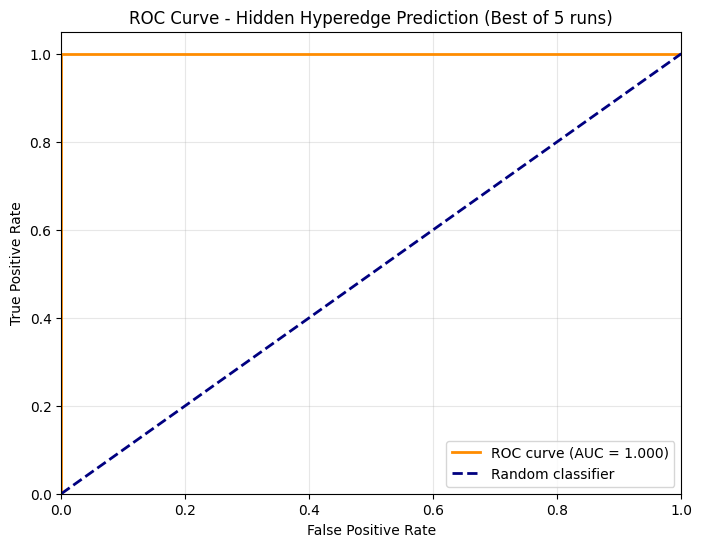

Evaluating structural properties using best run...

ENHANCED HPRA ANALYSIS RESULTS (MULTIPLE RUNS + JACCARD SIMILARITY)

Hypergraph Information:
  Number of hyperedges (training): 33
  Number of nodes: 33
  Average hidden hyperedge size: 4.00
  Total predictions: 500 (5 runs × 100 each)

Jaccard Similarity Analysis:
  Average Jaccard Similarity: 0.5111 ± 0.0427
  Best Run Jaccard Similarity: 0.5667
  Individual Hidden HE Similarities: ['0.600', '0.600', '0.500']

Machine Learning Scores (Jaccard-based, averaged over 5 runs):
  F1 Score: 0.7962 ± 0.0635
  Recall: 1.0000 ± 0.0000
  Precision: 0.6660 ± 0.0880
  Accuracy: 0.8180 ± 0.0560
  ROC-AUC: 1.0000 ± 0.0000
  Log Loss: 0.6899 ± 0.0136
  Matthews Correlation Coefficient: 0.6907 ± 0.0829

Machine Learning Scores (Exact matching, for comparison):
  F1 Score: 0.0000 ± 0.0000
  Recall: 0.0000 ± 0.0000
  Precision: 0.0000 ± 0.0000
  ROC-AUC: 0.5000 ± 0.0000

Structural Evaluation Scores (Best Run):
  Avg. Internal Connectivity (Predicted)

In [8]:
# Karate Club Clique Hypergraph (Zachary, 1977)
karate_club_clique_hg = {
    'clique_0': {0, 1, 2, 3, 13}, 
    'clique_1': {0, 1, 2, 3, 7}, 
    'clique_2': {8, 30, 32, 33}, 
    'clique_3': {23, 29, 32, 33}, 
    'clique_4': {0, 1, 17}, 
    'clique_5': {0, 1, 19}, 
    'clique_6': {0, 1, 21}, 
    'clique_7': {0, 4, 10}, 
    'clique_8': {0, 4, 6}, 
    'clique_9': {0, 5, 10}, 
    'clique_10': {0, 5, 6}, 
    'clique_11': {0, 2, 8}, 
    'clique_12': {0, 3, 12}, 
    'clique_13': {2, 8, 32}, 
    'clique_14': {5, 6, 16}, 
    'clique_15': {14, 32, 33}, 
    'clique_16': {15, 32, 33}, 
    'clique_17': {18, 32, 33}, 
    'clique_18': {20, 32, 33}, 
    'clique_19': {22, 32, 33}, 
    'clique_20': {31, 32, 33}, 
    'clique_21': {26, 29, 33}, 
    'clique_22': {23, 27, 33}, 
    'clique_23': {28, 31, 33}, 
    'clique_24': {24, 25, 31}, 
    'clique_25': {0, 11}, 
    'clique_26': {0, 31}, 
    'clique_27': {1, 30}, 
    'clique_28': {2, 9}, 
    'clique_29': {2, 27}, 
    'clique_30': {2, 28}, 
    'clique_31': {9, 33}, 
    'clique_32': {13, 33}, 
    'clique_33': {19, 33}, 
    'clique_34': {24, 27}, 
    'clique_35': {23, 25}
}

# Define hidden hyperedges (you can customize this list)
hidden_hyperedges = ['clique_0', 'clique_2', 'clique_15']  # Hide 3 hyperedges

print("\n\nExample 2: Karate Club Clique Hypergraph")
print(f"Number of nodes: {len(set.union(*karate_club_clique_hg.values()))}")
print(f"Number of hyperedges: {len(karate_club_clique_hg)}")

results_karate = specific_hyperedge_prediction_analysis(karate_club_clique_hg, hidden_hyperedges, num_predictions=100, plot_roc=True)
print_results_complete(results_karate)

### Example 3: Les Miserables Clique Hypergraph

Les Misérables (Knuth, 1993) hypergraph representation where nodes are characters and hyperedges correspond to cliques in the original character co-occurrence graph of Victor Hugo's novel.



Example 3: Les Miserables Clique Hypergraph
Number of nodes: 67
Number of hyperedges: 59
Starting Enhanced Specific Hyperedge Prediction Analysis...
Original hypergraph: 59 hyperedges
Hidden hyperedges: ['clique_0', 'clique_6', 'clique_10']
Running 5 independent runs with 100 predictions each
Training hypergraph: 56 hyperedges (removed 3 hidden)
Training incidence matrix shape: (65, 56) (nodes x hyperedges)
Computed adjacency matrix for HRA scores from training data
Average hidden hyperedge size: 8.33

Run 1/5 (seed: 42)
  Avg Jaccard Similarity: 0.5852
  Exact F1: 0.0000, Jaccard F1: 0.6753

Run 2/5 (seed: 1042)
  Avg Jaccard Similarity: 0.6894
  Exact F1: 0.0000, Jaccard F1: 0.8222

Run 3/5 (seed: 2042)
  Avg Jaccard Similarity: 0.6282
  Exact F1: 0.0000, Jaccard F1: 0.8235

Run 4/5 (seed: 3042)
  Avg Jaccard Similarity: 0.6101
  Exact F1: 0.0000, Jaccard F1: 0.8046

Run 5/5 (seed: 4042)
  Avg Jaccard Similarity: 0.6182
  Exact F1: 0.0000, Jaccard F1: 0.7857

Computing averages acr

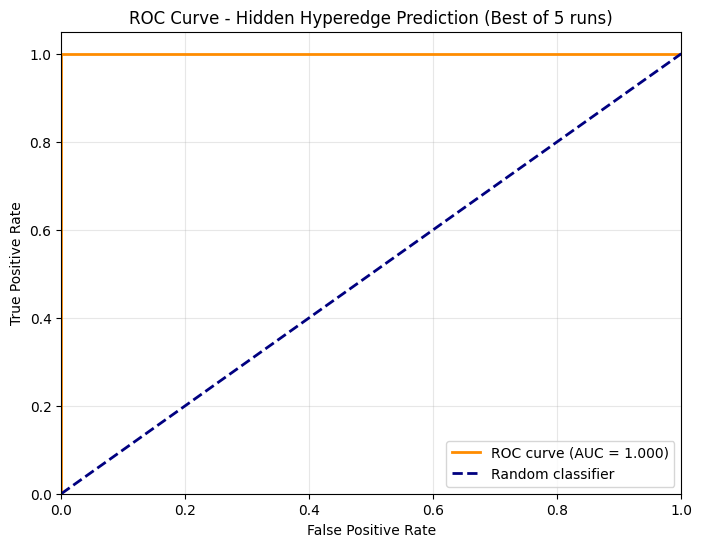

Evaluating structural properties using best run...

ENHANCED HPRA ANALYSIS RESULTS (MULTIPLE RUNS + JACCARD SIMILARITY)

Hypergraph Information:
  Number of hyperedges (training): 56
  Number of nodes: 65
  Average hidden hyperedge size: 8.33
  Total predictions: 500 (5 runs × 100 each)

Jaccard Similarity Analysis:
  Average Jaccard Similarity: 0.6262 ± 0.0347
  Best Run Jaccard Similarity: 0.6894
  Individual Hidden HE Similarities: ['0.500', '0.818', '0.750']

Machine Learning Scores (Jaccard-based, averaged over 5 runs):
  F1 Score: 0.7823 ± 0.0552
  Recall: 1.0000 ± 0.0000
  Precision: 0.6456 ± 0.0706
  Accuracy: 0.8180 ± 0.0354
  ROC-AUC: 1.0000 ± 0.0000
  Log Loss: 0.6743 ± 0.0083
  Matthews Correlation Coefficient: 0.6859 ± 0.0547

Machine Learning Scores (Exact matching, for comparison):
  F1 Score: 0.0000 ± 0.0000
  Recall: 0.0000 ± 0.0000
  Precision: 0.0000 ± 0.0000
  ROC-AUC: 0.5000 ± 0.0000

Structural Evaluation Scores (Best Run):
  Avg. Internal Connectivity (Predicted)

In [9]:
# Les Miserables Clique Hypergraph
lesmiserables_clique_hg = {
    'clique_0': {'Anzelma', 'Cosette', 'Eponine', 'Gavroche', 'Marius', 'MmeThenardier', 'Thenardier', 'Valjean'}, 
    'clique_1': {'Enjolras', 'Feuilly', 'Gavroche', 'Joly', 'Marius'}, 
    'clique_2': {'Combeferre', 'Enjolras', 'Feuilly', 'Gavroche', 'Joly', 'Marius'}, 
    'clique_3': {'Combeferre', 'Courfeyrac', 'Enjolras', 'Feuilly', 'Gavroche', 'Joly', 'Marius'}, 
    'clique_4': {'Bahorel', 'Combeferre', 'Courfeyrac', 'Enjolras', 'Feuilly', 'Gavroche', 'Joly', 'Marius'}, 
    'clique_5': {'Bahorel', 'Bossuet', 'Combeferre', 'Courfeyrac', 'Enjolras', 'Feuilly', 'Gavroche', 'Joly', 'Marius'}, 
    'clique_6': {'Bahorel', 'Bossuet', 'Combeferre', 'Courfeyrac', 'Enjolras', 'Feuilly', 'Gavroche', 'Joly', 'Marius', 'Prouvaire'}, 
    'clique_7': {'Babet', 'Claquesous', 'Gueulemer', 'Montparnasse'}, 
    'clique_8': {'Babet', 'Claquesous', 'Gueulemer', 'Montparnasse', 'Thenardier'}, 
    'clique_9': {'Babet', 'Claquesous', 'Gueulemer', 'Montparnasse', 'Thenardier', 'Valjean'}, 
    'clique_10': {'Babet', 'Claquesous', 'Gueulemer', 'Javert', 'Montparnasse', 'Thenardier', 'Valjean'}, 
    'clique_11': {'Cosette', 'Javert', 'Marius', 'Valjean'}, 
    'clique_12': {'Cosette', 'Marius', 'Toussaint', 'Valjean'}, 
    'clique_13': {'Cosette', 'Marius', 'Valjean'}, 
    'clique_14': {'Gillenormand', 'Marius', 'MlleGillenormand'}, 
    'clique_15': {'Gillenormand', 'Marius', 'MlleGillenormand', 'MmePontmercy'}, 
    'clique_16': {'Cosette', 'Fantine', 'Javert', 'Valjean'}, 
    'clique_17': {'Cosette', 'Fantine', 'MmeThenardier', 'Thenardier', 'Valjean'}, 
    'clique_18': {'Bamatabois', 'Fantine', 'Javert', 'Valjean'}, 
    'clique_19': {'Fantine', 'Favourite', 'Listolier', 'Tholomyes'}, 
    'clique_20': {'Dahlia', 'Fantine', 'Favourite', 'Listolier', 'Tholomyes'}, 
    'clique_21': {'Dahlia', 'Fantine', 'Favourite', 'Listolier', 'Tholomyes', 'Zephine'}, 
    'clique_22': {'Dahlia', 'Fameuil', 'Fantine', 'Favourite', 'Listolier', 'Tholomyes', 'Zephine'}, 
    'clique_23': {'Blacheville', 'Dahlia', 'Fameuil', 'Fantine', 'Favourite', 'Listolier', 'Tholomyes', 'Zephine'}, 
    'clique_24': {'Simplice', 'Valjean'}, 
    'clique_25': {'Champmathieu', 'Valjean'}, 
    'clique_26': {'Brevet', 'Valjean'}, 
    'clique_27': {'Chenildieu', 'Valjean'}, 
    'clique_28': {'Cochepaille', 'Valjean'}, 
    'clique_29': {'Judge', 'Valjean'}, 
    'clique_30': {'Fauchelevent', 'MotherInnocent', 'Valjean'}, 
    'clique_31': {'Fantine', 'Marguerite', 'Valjean'}, 
    'clique_32': {'Javert', 'Valjean', 'Woman1'}, 
    'clique_33': {'Fauchelevent', 'Javert', 'Valjean'}, 
    'clique_34': {'Eponine', 'Marius', 'Thenardier'}, 
    'clique_35': {'Marius', 'Pontmercy', 'Thenardier'}, 
    'clique_36': {'BaronessT', 'Gillenormand', 'Marius'}, 
    'clique_37': {'Gavroche', 'MmeBurgon'}, 
    'clique_38': {'Jondrette', 'MmeBurgon'}, 
    'clique_39': {'Mabeuf', 'MotherPlutarch'}, 
    'clique_40': {'Fauchelevent', 'Gribier'}, 
    'clique_41': {'Count', 'Myriel'}, 
    'clique_42': {'Cravatte', 'Myriel'}, 
    'clique_43': {'Gervais', 'Valjean'}, 
    'clique_44': {'Labarre', 'Valjean'}, 
    'clique_45': {'MmeDeR', 'Valjean'}, 
    'clique_46': {'Scaufflaire', 'Valjean'}, 
    'clique_47': {'Isabeau', 'Valjean'}, 
    'clique_48': {'MmePontmercy', 'Pontmercy'}, 
    'clique_49': {'MlleGillenormand', 'MmePontmercy'}, 
    'clique_50': {'MlleGillenormand', 'MlleVaubois'}, 
    'clique_51': {'Myriel', 'OldMan'}, 
    'clique_52': {'Geborand', 'Myriel'}, 
    'clique_53': {'CountessDeLo', 'Myriel'}, 
    'clique_54': {'Champtercier', 'Myriel'}, 
    'clique_55': {'Magnon', 'MmeThenardier'}, 
    'clique_56': {'Gillenormand', 'Magnon'}, 
    'clique_57': {'Boulatruelle', 'Thenardier'}, 
    'clique_58': {'Myriel', 'Napoleon'}
}

# Define hidden hyperedges (you can customize this list)
hidden_hyperedges = ['clique_0', 'clique_6', 'clique_10']  # Hide 3 hyperedges

print("\n\nExample 3: Les Miserables Clique Hypergraph")
print(f"Number of nodes: {len(set.union(*lesmiserables_clique_hg.values()))}")
print(f"Number of hyperedges: {len(lesmiserables_clique_hg)}")

results_lesmiserables = specific_hyperedge_prediction_analysis(lesmiserables_clique_hg, hidden_hyperedges, num_predictions=100, plot_roc=True)
print_results_complete(results_lesmiserables)

### Example 4: Randomly Generated Hypergraph



Example 4: Random Hypergraph
Number of nodes: 50
Number of hyperedges: 25
Hidden hyperedges: ['rand_he_21', 'rand_he_4', 'rand_he_1']
Starting Enhanced Specific Hyperedge Prediction Analysis...
Original hypergraph: 25 hyperedges
Hidden hyperedges: ['rand_he_21', 'rand_he_4', 'rand_he_1']
Running 5 independent runs with 50 predictions each
Training hypergraph: 22 hyperedges (removed 3 hidden)
Training incidence matrix shape: (47, 22) (nodes x hyperedges)
Computed adjacency matrix for HRA scores from training data
Average hidden hyperedge size: 7.67

Run 1/5 (seed: 42)
  Avg Jaccard Similarity: 0.2879
  Exact F1: 0.0000, Jaccard F1: 0.1429

Run 2/5 (seed: 1042)
  Avg Jaccard Similarity: 0.2789
  Exact F1: 0.0000, Jaccard F1: 0.0541

Run 3/5 (seed: 2042)
  Avg Jaccard Similarity: 0.2778
  Exact F1: 0.0000, Jaccard F1: 0.0690

Run 4/5 (seed: 3042)
  Avg Jaccard Similarity: 0.3056
  Exact F1: 0.0000, Jaccard F1: 0.1481

Run 5/5 (seed: 4042)
  Avg Jaccard Similarity: 0.3157
  Exact F1: 0.0

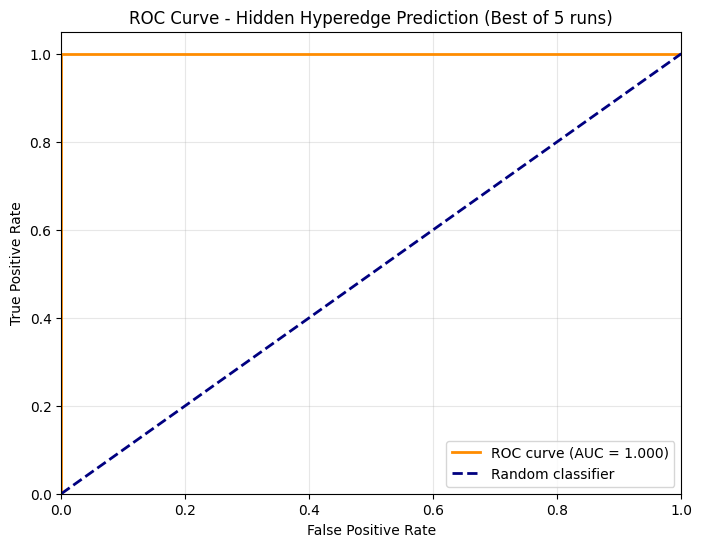

Evaluating structural properties using best run...

ENHANCED HPRA ANALYSIS RESULTS (MULTIPLE RUNS + JACCARD SIMILARITY)

Hypergraph Information:
  Number of hyperedges (training): 22
  Number of nodes: 47
  Average hidden hyperedge size: 7.67
  Total predictions: 250 (5 runs × 50 each)

Jaccard Similarity Analysis:
  Average Jaccard Similarity: 0.2932 ± 0.0150
  Best Run Jaccard Similarity: 0.3157
  Individual Hidden HE Similarities: ['0.333', '0.364', '0.250']

Machine Learning Scores (Jaccard-based, averaged over 5 runs):
  F1 Score: 0.1242 ± 0.0561
  Recall: 1.0000 ± 0.0000
  Precision: 0.0672 ± 0.0320
  Accuracy: 0.4720 ± 0.0909
  ROC-AUC: 1.0000 ± 0.0000
  Log Loss: 0.7624 ± 0.0052
  Matthews Correlation Coefficient: 0.1717 ± 0.0558

Machine Learning Scores (Exact matching, for comparison):
  F1 Score: 0.0000 ± 0.0000
  Recall: 0.0000 ± 0.0000
  Precision: 0.0000 ± 0.0000
  ROC-AUC: 0.5000 ± 0.0000

Structural Evaluation Scores (Best Run):
  Avg. Internal Connectivity (Predicted):

In [10]:
# Generate a random hypergraph
vertices_random = list(range(1, 51))  # 50 nodes
hyperedge_names_random = [f'rand_he_{i}' for i in range(1, 31)] # 30 hyperedges

random_hg = hypergraph_random_creator(
    vertices=vertices_random,
    hyperedge_names=hyperedge_names_random,
    m=25,  # Create 25 hyperedges
    minv=3,  # Min 3 nodes per hyperedge
    maxv=8,  # Max 8 nodes per hyperedge
    weighted=False
)

# Define hidden hyperedges (randomly select some)
import random as rand
rand.seed(42)
all_hyperedge_keys = list(random_hg.keys())
hidden_hyperedges = rand.sample(all_hyperedge_keys, 3)  # Hide 3 random hyperedges

print("\n\nExample 4: Random Hypergraph")
print(f"Number of nodes: {len(vertices_random)}")
print(f"Number of hyperedges: {len(random_hg)}")
print(f"Hidden hyperedges: {hidden_hyperedges}")

results_random = specific_hyperedge_prediction_analysis(random_hg, hidden_hyperedges, num_predictions=50, plot_roc=True)
print_results_complete(results_random)

## Comparison Tables

In [12]:
def create_complete_comparison_table_with_save(results_list, example_names, 
                                               method_name, task_name, 
                                               save_dir="results", 
                                               display_results=True):
    
    comparison_data = []
    
    for i, results in enumerate(results_list):
        hg_info = results['hypergraph_info']
        ml_scores = results['ml_scores']
        eval_scores = results['structural_evaluation']
        
        row = {
            'Hypergraph': example_names[i],
            'Nodes': hg_info['num_nodes'],
            'Hyperedges': hg_info['num_hyperedges'],
            'Avg HE Size': round(hg_info['avg_hyperedge_size'], 2),
            # The 7 ML Scores
            'F1 Score': round(ml_scores['f1'], 4),
            'Recall': round(ml_scores['recall'], 4),
            'Precision': round(ml_scores['precision'], 4),
            'Accuracy': round(ml_scores['accuracy'], 4),
            'ROC-AUC': round(ml_scores['roc_auc'], 4),
            'Log Loss': round(ml_scores['log_loss'], 4) if ml_scores['log_loss'] != float('inf') else 'inf',
            'Matthews Coeff': round(ml_scores['matthews_corrcoef'], 4),
            # Structural Scores
            'Predicted Connectivity': round(eval_scores['avg_predicted_internal_connectivity'], 4),
            'Random Connectivity': round(eval_scores['avg_random_baseline_connectivity'], 4),
            'Connectivity Ratio': round(eval_scores['connectivity_ratio'], 2),
            'Avg Node Degree (Overall)': round(eval_scores['avg_overall_node_degree'], 2),
            'Avg Node Degree (Predicted)': round(eval_scores['avg_node_degree_in_predictions'], 2)
        }
        comparison_data.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(comparison_data)
    
    # Save results for aggregation
    save_results_for_aggregation(df, method_name, task_name, save_dir)
    
    # Display results if requested (original functionality)
    if display_results:
        display_comparison_tables(df)
    
    return df

def save_results_for_aggregation(df, method_name, task_name, save_dir):
    """
    Save the comparison results in a structured format for later aggregation.
    """
    # Create directory structure
    method_dir = Path(save_dir) / method_name
    method_dir.mkdir(parents=True, exist_ok=True)
    
    # Prepare data for saving
    save_data = {
        'metadata': {
            'method': method_name,
            'task': task_name,
            'timestamp': datetime.now().isoformat(),
            'num_hypergraphs': len(df)
        },
        'results': df.to_dict('records')
    }
    
    # Save to JSON file
    filename = f"{task_name}_results.json"
    filepath = method_dir / filename
    
    with open(filepath, 'w') as f:
        json.dump(save_data, f, indent=2, default=str)
    
    print(f"✓ Results saved to: {filepath}")

def display_comparison_tables(df):
    """
    Display the comparison tables in the original format.
    """
    # Set pandas display options for better formatting
    pd.set_option('display.max_columns', None)
    pd.set_option('display.precision', 4)

    # 1. ML SCORES COMPARISON TABLE (FIRST)
    print("\n" + "="*90)
    print("ML SCORES COMPARISON TABLE")
    print("="*90)
    ml_columns = ['Hypergraph', 'F1 Score', 'Recall', 'Precision', 'Accuracy', 'ROC-AUC', 'Log Loss', 'Matthews Coeff']
    ml_df = df[ml_columns]

    # Format ML table nicely
    print(f"{'Hypergraph':<20} {'F1':<8} {'Recall':<8} {'Precision':<10} {'Accuracy':<9} {'ROC-AUC':<8} {'Log Loss':<9} {'Matthews':<9}")
    print("-" * 90)
    for i, row in ml_df.iterrows():
        # Handle potential string values (like 'inf')
        log_loss_str = f"{row['Log Loss']:.4f}" if isinstance(row['Log Loss'], (int, float)) else str(row['Log Loss'])
        print(f"{row['Hypergraph']:<20} {row['F1 Score']:<8.4f} {row['Recall']:<8.4f} {row['Precision']:<10.4f} {row['Accuracy']:<9.4f} {row['ROC-AUC']:<8.4f} {log_loss_str:<9} {row['Matthews Coeff']:<9.4f}")
    print("="*90)

    # 2. STRUCTURAL SCORES COMPARISON TABLE
    print("\n\n" + "="*100)
    print("STRUCTURAL SCORES COMPARISON TABLE")
    print("="*100)

    structural_columns = ['Hypergraph', 'Nodes', 'Hyperedges', 'Avg HE Size', 'Predicted Connectivity', 
                         'Random Connectivity', 'Connectivity Ratio']
    structural_df = df[structural_columns]

    # Format structural table nicely
    print(f"{'Hypergraph':<20} {'Nodes':<6} {'HEdges':<7} {'Avg Size':<9} {'Pred Conn':<10} {'Rand Conn':<10} {'Conn Ratio':<10}")
    print("-" * 100)
    for i, row in structural_df.iterrows():
        print(f"{row['Hypergraph']:<20} {row['Nodes']:<6} {row['Hyperedges']:<7} {row['Avg HE Size']:<9.2f} {row['Predicted Connectivity']:<10.4f} {row['Random Connectivity']:<10.4f} {row['Connectivity Ratio']:<10.2f}")
    print("="*100)

    # 3. COMPLETE COMPARISON TABLE (SIMPLIFIED)
    print("\n\n" + "="*80)
    print("COMPLETE COMPARISON TABLE - SUMMARY")
    print("="*80)
    print("(Showing key metrics only for readability)")
    print("-"*80)
    summary_columns = ['Hypergraph', 'Nodes', 'Hyperedges', 'F1 Score', 'ROC-AUC', 'Connectivity Ratio']
    summary_df = df[summary_columns]
    print(f"{'Hypergraph':<20} {'Nodes':<6} {'HEdges':<8} {'F1':<8} {'ROC-AUC':<8} {'Conn Ratio':<11}")
    print("-" * 80)
    for i, row in summary_df.iterrows():
        print(f"{row['Hypergraph']:<20} {row['Nodes']:<6} {row['Hyperedges']:<8} {row['F1 Score']:<8.4f} {row['ROC-AUC']:<8.4f} {row['Connectivity Ratio']:<11.2f}")
    print("="*80)

example_names = ['Southern Women', 'Karate Club', 'Les Miserables', 'Random Hypergraph']
results_list = [results_sw, results_karate, results_lesmiserables, results_random]

comparison_df = create_complete_comparison_table_with_save(
    results_list=results_list,
    example_names=example_names,
    method_name='HPRA',
    task_name='hypergraph_prediction',
    save_dir='results',
    display_results=True
)

✓ Results saved to: results/HPRA/hypergraph_prediction_results.json

ML SCORES COMPARISON TABLE
Hypergraph           F1       Recall   Precision  Accuracy  ROC-AUC  Log Loss  Matthews 
------------------------------------------------------------------------------------------
Southern Women       0.7871   0.6520   1.0000     0.6520    0.5000   0.0000    0.0000   
Karate Club          0.7962   1.0000   0.6660     0.8180    1.0000   0.6899    0.6907   
Les Miserables       0.7823   1.0000   0.6456     0.8180    1.0000   0.6743    0.6859   
Random Hypergraph    0.1242   1.0000   0.0672     0.4720    1.0000   0.7624    0.1717   


STRUCTURAL SCORES COMPARISON TABLE
Hypergraph           Nodes  HEdges  Avg Size  Pred Conn  Rand Conn  Conn Ratio
----------------------------------------------------------------------------------------------------
Southern Women       18     12      12.00     0.4679     0.3468     1.35      
Karate Club          33     33      4.00      0.5861     0.0860     6.82